In [20]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as st

from scipy.stats import norm
from scipy import stats
# import math
from sklearn import linear_model
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PowerTransformer
# from sklearn.compose import make_column_transformer
# from sklearn.linear_model import LarsCV
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import LassoLarsCV
# from sklearn.linear_model import ElasticNetCV
# from sklearn.linear_model import OrthogonalMatchingPursuitCV
# from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import PassiveAggressiveRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
# from sklearn.ensemble import BaggingRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.neural_network import MLPRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.ensemble import VotingRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [21]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        1095 non-null   int32  
 1   tapis_oil_price_t_minus_10   1095 non-null   int64  
 2   national_avg_price           1095 non-null   int32  
 3   sgd_exchange_rate_t_minus_6  1095 non-null   float64
 4   usd_exchange_rate            1095 non-null   float64
 5   volume_in_ml                 1095 non-null   float64
 6   wholesale_price_t_minus_4    1095 non-null   int64  
 7   wholesale_cluster_label      1095 non-null   int64  
 8   tapis_oil_cluster_label      1095 non-null   int64  
 9   price_t_plus_1               1095 non-null   int64  
dtypes: float64(3), int32(2), int64(5)
memory usage: 85.5 KB


In [23]:
df.tail(5)

price  tapis_oil_price_t_minus_10  national_avg_price  \
2019-12-27   1608                        7084                1336   
2019-12-28   1589                        7103                1349   
2019-12-29   1579                        7159                1349   
2019-12-30   1602                        7198                1349   
2019-12-31   1609                        7177                1357   

            sgd_exchange_rate_t_minus_6  usd_exchange_rate  volume_in_ml  \
2019-12-27                       0.9386             0.6978          14.3   
2019-12-28                       0.9386             0.6995          14.3   
2019-12-29                       0.9386             0.6995          14.3   
2019-12-30                       0.9382             0.6995          14.3   
2019-12-31                       0.9377             0.7022          14.3   

            wholesale_price_t_minus_4  wholesale_cluster_label  \
2019-12-27                       1332                        0   
2019-12-28                       1332                        0   
2019-12-29                       1335                        0   
2019-12-30                       1336                        0   
2019-12-31                       1338                        0   

            tapis_oil_cluster_label  price_t_plus_1  
2019-12-27                        0            1589  
2019-12-28                        0            1579  
2019-12-29                        0            1602  
2019-12-30                        0            1609  
2019-12-31                        0            1609

In [24]:
print('P-value (probability that data (price) not stationary)', st.adfuller(df.price)[1])

P-value (probability that data (price) not stationary) 0.4707242487238074


In [25]:
print('P-value (probability that data (price) not stationary)', st.kpss(df.price, lags='auto')[1])

P-value (probability that data (price) not stationary) 0.01


/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [26]:
# 10.0 ** -np.arange(1, 7)
np.logspace(-5, 3, 5)

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03])

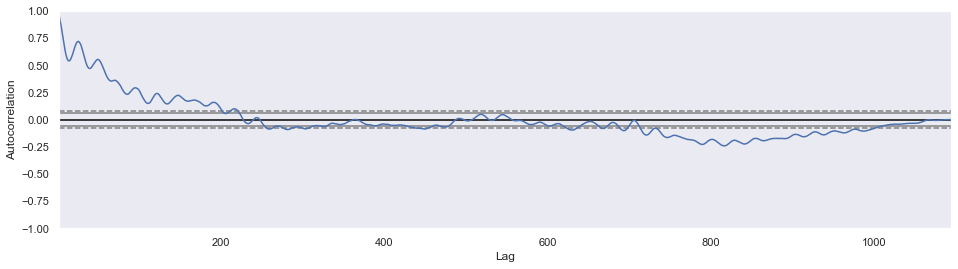

In [27]:
plt.figure(figsize = (16, 4))
autocorrelation_plot(df.price)
plt.show()

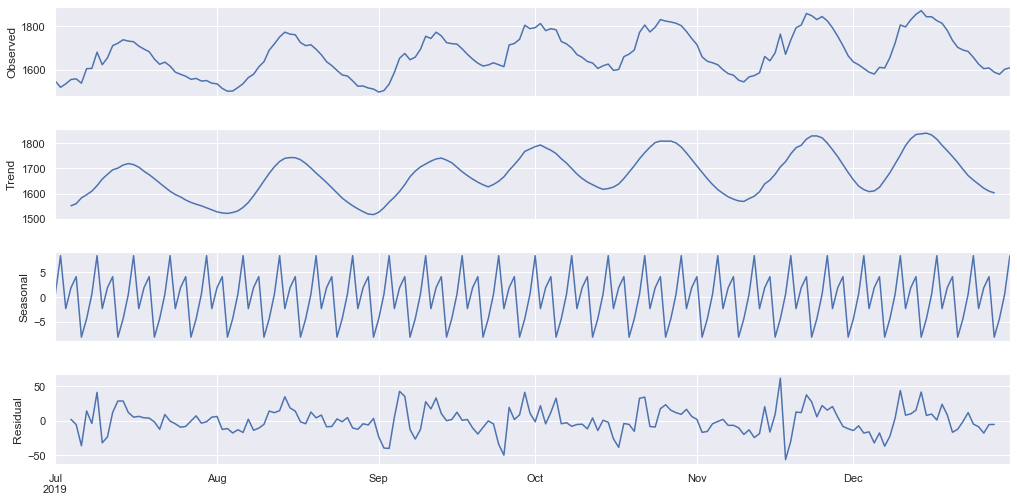

In [28]:
decom_result = sm.tsa.seasonal_decompose(df[df.index >= '2019-07-01'].price)
fig = decom_result.plot()
fig.set_size_inches(16, 8)
plt.show()

In [29]:
df['price_differenced'] = df.apply(lambda se: se.price_t_plus_1 - se.price, axis=1)

In [30]:
print('P-value (probability that data (price_differenced) not stationary)', st.adfuller(df.price_differenced)[1])

P-value (probability that data (price_differenced) not stationary) 5.016297201311819e-24


In [31]:
print('P-value (probability that data (price) not stationary)', st.kpss(df.price_differenced, lags='auto')[1])

P-value (probability that data (price) not stationary) 0.1


/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


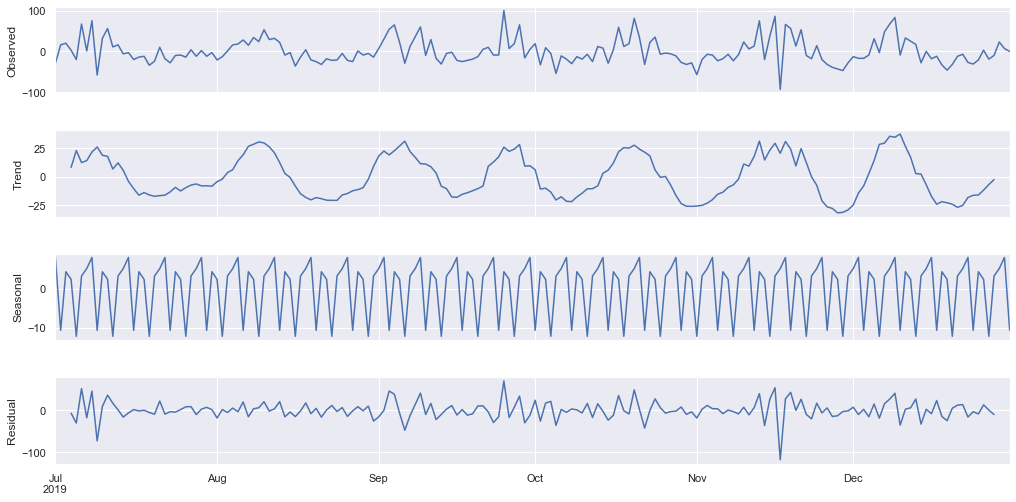

In [32]:
decom_result = sm.tsa.seasonal_decompose(df[df.index >= '2019-07-01'].price_differenced)
fig = decom_result.plot()
fig.set_size_inches(16, 8)
plt.show()

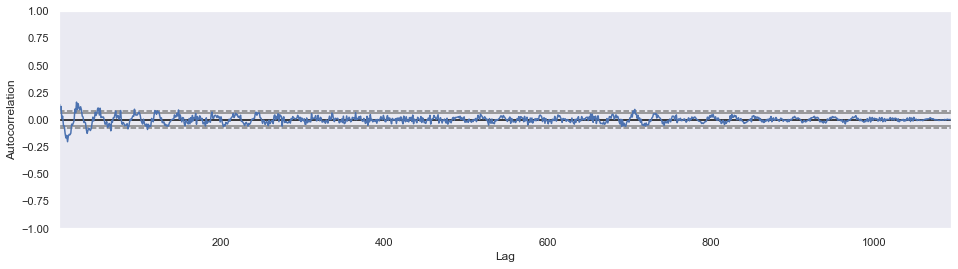

In [33]:
plt.figure(figsize = (16, 4))
autocorrelation_plot(df.price_differenced)
plt.show()

mu = 0.18 and sigma = 28.10



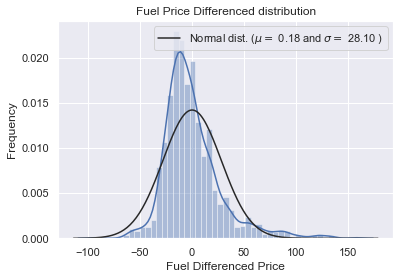

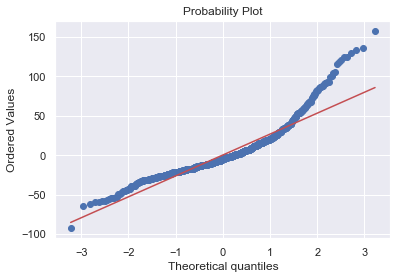

Skewness: 1.557122
Kurtosis: 4.384021


In [45]:
sns.distplot(df.price_differenced, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df.price_differenced)
print('mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('Fuel Differenced Price')
plt.title('Fuel Price Differenced distribution')

fig = plt.figure()
res = stats.probplot(df.price_differenced, plot=plt)
plt.show()

print("Skewness: %f" % df.price_differenced.skew())
print("Kurtosis: %f" % df.price_differenced.kurt())

In [46]:
non_categorical_features = ['price','tapis_oil_price_t_minus_10','wholesale_price_t_minus_4']
# non_categorical_features = ['price','tapis_oil_price','national_avg_price','usd_exchange_rate','volume_in_ml',
#                             'day','week','weekday']

In [47]:
# these features slightly decrease the accuracy
# del df['sgd_exchange_rate_t_minus_6']
del df['usd_exchange_rate']
del df['volume_in_ml']
del df['national_avg_price']
del df['wholesale_cluster_label']
del df['tapis_oil_cluster_label']
del df['price']

In [48]:
df

tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2017-01-01                        5863                       1.0425   
2017-01-02                        5863                       1.0425   
2017-01-03                        5863                       1.0425   
2017-01-04                        5863                       1.0425   
2017-01-05                        5863                       1.0425   
...                                ...                          ...   
2019-12-27                        7084                       0.9386   
2019-12-28                        7103                       0.9386   
2019-12-29                        7159                       0.9386   
2019-12-30                        7198                       0.9382   
2019-12-31                        7177                       0.9377   

            wholesale_price_t_minus_4  price_t_plus_1  price_differenced  
2017-01-01                       1183            1436               19.0  
2017-01-02                       1183            1409              -27.0  
2017-01-03                       1183            1542              133.0  
2017-01-04                       1183            1582               40.0  
2017-01-05                       1183            1529              -53.0  
...                               ...             ...                ...  
2019-12-27                       1332            1589              -19.0  
2019-12-28                       1332            1579              -10.0  
2019-12-29                       1335            1602               23.0  
2019-12-30                       1336            1609                7.0  
2019-12-31                       1338            1609                0.0  

[1095 rows x 5 columns]

In [49]:
y = df.price_t_plus_1
del df['price_t_plus_1']

In [50]:
tscv = TimeSeriesSplit(n_splits=2)
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state, shuffle=False)

In [51]:
for train_index, test_index in tscv.split(df):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    break

In [52]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [55]:
error_tolerance_percentage = 2.5
est = linear_model.LinearRegression(normalize=False)

In [59]:
X_train[:1]

tapis_oil_price_t_minus_10  sgd_exchange_rate_t_minus_6  \
2017-01-01                        5863                       1.0425   

            wholesale_price_t_minus_4  price_differenced  
2017-01-01                       1183               19.0

In [56]:
est.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
est.score(X_test, y_test)

0.37392640550599077

In [58]:
y_hat = np.rint(est.predict(X_test))
get_relative_accuracy(y_test.values, y_hat, error_tolerance_percentage)

0.37534246575342467